# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [24]:
import numpy as np
from collections import Counter # Used for counting the number of unique labels
import cv2
import matplotlib.pyplot as plt
import os
import matplotlib.pylab as plty
import pandas as pd
import seaborn as sns

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
validation_file = 'valid.p' 
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# Number of validation examples
n_valid = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = np.shape(X_train[0])   #We take the first image size

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(Counter(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


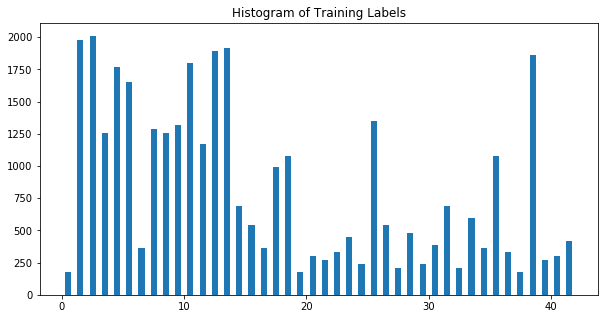

In [4]:
plt.figure(figsize=(10,5))
plt.hist(y_train, histtype='bar', bins = list(range(0,43)),rwidth=0.5)
plt.title("Histogram of Training Labels")

plt.show()

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

The class of the printed image is 4


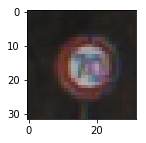

In [5]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

index = random.randint(0,len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(2,2))
plt.imshow(image)
print('The class of the printed image is',y_train[index])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

#### Pre-process the Data Set (normalization, grayscale, etc.)

In order to check the effect of preprocessing methods, we can write the various forms of preprocessing as a function and then call the preproceesing that we want during runtime. The following preprocessing methods are evaluated

1. Converting to grayscale
2. Normalization of grayscale image between [0,1]
3. Scaling of grayscale image with zero mean and unit variance [-0.5,0.5]
4. Normalization on RGB image between [0,1]
5. Scaling on RGB with zero mean and unit variance [-0.5,0.5]


In [6]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.
def preprocessing(X_train, option):

    import cv2
    from ipywidgets import FloatProgress
    from IPython.display import display
    from sklearn.preprocessing import normalize
    from sklearn.preprocessing import scale

    # Float bar to display the status of processing
    max_len = len(X_train)
    f = FloatProgress(min=0,max=max_len)
    display(f)


    if option == 1 or option == 2 or option == 3:
        # Variables for storing the output images
        X_train_gray = np.zeros([len(X_train),32,32])
        X_train_grayNormalized = np.zeros([len(X_train),32,32])
        X_train_grayScaled = np.zeros([len(X_train),32,32])

        for index,img in enumerate(X_train):
            f.value = index
            ## Convert all the RGB photos to grayscale using the grayscale operation of openCV
            img = X_train[index]

            X_train_gray[index] = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            
        if option == 2:
            for index,img in enumerate(X_train):
                X_train_grayNormalized[index] = cv2.normalize(X_train_gray[index], 0, 255, cv2.NORM_MINMAX)
            return X_train_grayNormalized[:,:,:,np.newaxis]
        
        elif option == 3:
            for index,img in enumerate(X_train):
                X_train_grayScaled[index] = scale(X_train_gray[index])
            return X_train_grayScaled[:,:,:,np.newaxis] # Add a 4th dimension to use it in tensorflow
        
        else:
            return X_train_gray[:,:,:,np.newaxis]

    if option == 4:
        X_train_normalized = np.zeros([len(X_train),32,32,3])

        for index,img in enumerate(X_train):
            f.value = index

            norm_dst = np.zeros((32,32,3), np.uint8)
            
            X_train_normalized[index] = cv2.normalize(X_train[index],norm_dst, alpha=0, \
                                               beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        return X_train_normalized

    if option == 5:
        X_train_RGBscaled = np.zeros([len(X_train),32,32,3])

        for index,img in enumerate(X_train):
            f.value = index
            scaled_rgb = np.zeros((32,32,3), np.uint8)

            b = scale(X_train[index][:,:,0].astype(np.float64))
            g = scale(X_train[index][:,:,1].astype(np.float64))
            r = scale(X_train[index][:,:,2].astype(np.float64))
            
            scaled_rgb = (np.array([b,g,r], ndmin=3).T).astype(np.uint8)
            X_train_RGBscaled[index] = scaled_rgb
            

        return X_train_RGBscaled     

#### Run all the preprocessing actions in one go. 


In [7]:
%%time
# For training images
grayimage_train = preprocessing(X_train,1)
normalizedGray_train = preprocessing(X_train,2)
scaledGray_train = preprocessing(X_train,3)

normalizedRGB_train = preprocessing(X_train,4)
scaledRGB_train = preprocessing(X_train,5)

# For Validation images
grayimage_valid = preprocessing(X_valid,1)
normalizedGray_valid = preprocessing(X_valid,2)
scaledGray_valid = preprocessing(X_valid,3)

normalizedRGB_valid = preprocessing(X_valid,4)
scaledRGB_valid = preprocessing(X_valid,5)

CPU times: user 2min 4s, sys: 16.9 s, total: 2min 21s
Wall time: 2min 8s


Let us see how the preprocessing operations modify the image in general

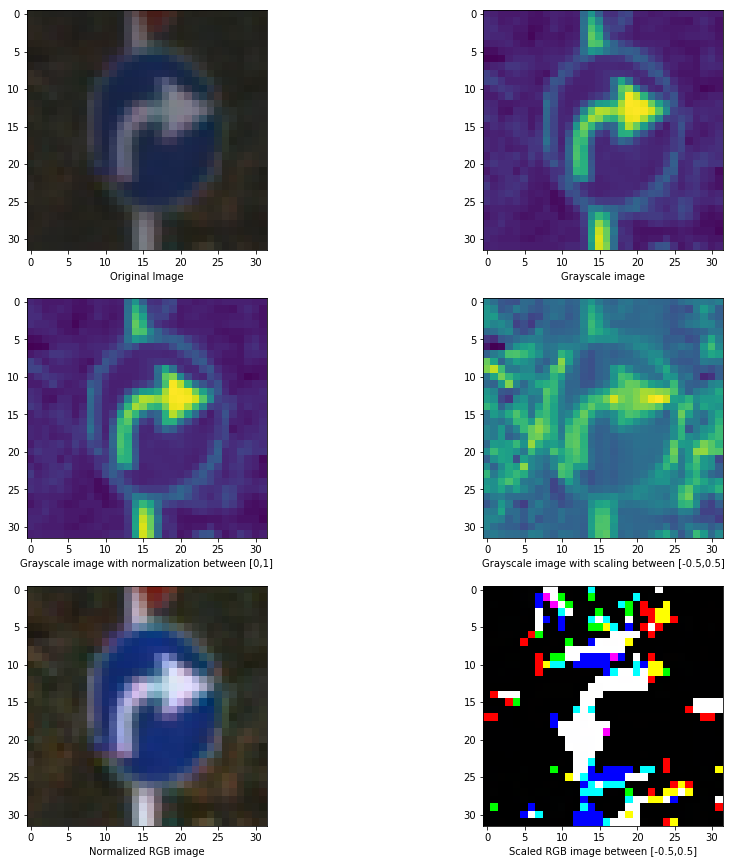

In [10]:
index = random.randint(0,len(X_train))

figure = plt.figure(figsize=(15,15))
actFigure = figure.add_subplot(321)
actFigure.set_xlabel('Original Image')

actFigure.imshow(X_train[index])

#processedfigure = plt.figure(figsize=(10,10))

grayscalePlot = figure.add_subplot(322)
grayscalePlot.imshow(grayimage_train[index][:,:,0])
grayscalePlot.set_xlabel('Grayscale image')

normalizedgrayPlot = figure.add_subplot(323)
normalizedgrayPlot.imshow(normalizedGray_train[index][:,:,0])
normalizedgrayPlot.set_xlabel('Grayscale image with normalization between [0,1]')

scaledgrayPlot = figure.add_subplot(324)
scaledgrayPlot.imshow(scaledGray_train[index][:,:,0])
scaledgrayPlot.set_xlabel('Grayscale image with scaling between [-0.5,0.5]')

normalizedRGBPlot = figure.add_subplot(325)
normalizedRGBPlot.imshow(normalizedRGB_train[index])
normalizedRGBPlot.set_xlabel('Normalized RGB image')

scaledRGBPlot = figure.add_subplot(326)
scaledRGBPlot.imshow(scaledRGB_train[index])
scaledRGBPlot.set_xlabel('Scaled RGB image between [-0.5,0.5]')



In [11]:
def returnProcessedData(processType, traindata = X_train, validdata = X_valid, testdata = X_test):
    if processType == 'RGB':
        return X_train, X_valid, X_test
    
    elif processType == 'grayscale':
        grayimage_train = preprocessing(X_train,1)
        grayimage_valid = preprocessing(X_valid,1)
        grayimage_test = preprocessing(X_test,1)
        return grayimage_train, grayimage_valid, grayimage_test
    
    elif processType == 'normalizedgray':
        normgray_train = preprocessing(X_train,2)
        normgray_valid = preprocessing(X_valid,2)
        normgray_test = preprocessing(X_test,2)
        return normgray_train, normgray_valid, normgray_test
        
    elif processType == 'scaledgray':
        scaledgray_train = preprocessing(X_train,3)
        scaledgray_valid = preprocessing(X_valid,3)
        scaledgray_test = preprocessing(X_test,3)
        return scaledgray_train, scaledgray_valid, scaledgray_test
    
    elif processType == 'normalizedRGB':
        normRGB_train = preprocessing(X_train,4)
        normRGB_valid = preprocessing(X_valid,4)
        normRGB_test = preprocessing(X_test,4)
        return normRGB_train, normRGB_valid, normRGB_test
    
    elif processType == 'scaledRGB':
        scaledRGB_train = preprocessing(X_train,5)
        scaledRGB_valid = preprocessing(X_valid,5)
        scaledRGB_test = preprocessing(X_test, 5)
        return scaledRGB_train, scaledRGB_valid, scaledRGB_test
    
    else:
        print("Unknown option. Please select from the following")
        print()
        print("RGB, grayscale, normalizedgray, scaledgray, normalizedRGB, scaledRGB")
        


In [ ]:
### RGB, grayscale, normalizedgray, scaledgray, normalizedRGB, scaledRGB

preprocesseddata = 'normalizedgray'
X_train, X_valid, X_test = returnProcessedData(preprocesseddata)

### Model Architecture

The model architecture is based on the 6-layer LeNet architecture. We can just change the sizes of input and output layers to train our traffic data. Since, for the traffic sign images, there are three dimensions of depth (RGB) instead of 1 for grayscale, the filter sizes in layer 1 are changed to (5,5,3,6). If we preprocess the the traffic sign images and convert them to grayscale, the same filter may be used.

For the output layer, we have 43 hot encoded labels instead of 10. Hence we change the output size to 43. Input remains the same 84. 

In [12]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten

def LeNet(x, depth):
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Solution: Layer 1: Convolutional input 32x32x3. Output = 28x28x6
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5,5,depth,6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides = [1,1,1,1], padding='VALID') + conv1_b
    
    # Solution: Activation
    conv1 = tf.nn.relu(conv1)
    
    # Solution: Pooling. INput = 28x28x6. Output = 14x14x6
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Solution: Layer 2: Convolutional Output = 10x10x16
    conv2_W = tf.Variable(tf.truncated_normal(shape = (5,5,6,16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides = [1,1,1,1], padding='VALID') + conv2_b
    
    # Solution: Activation
    conv2 = tf.nn.relu(conv2)
    
    # Solution: Pooling. Input = 10x10x16. Output = 5x5x16
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides = [1,2,2,1], padding='VALID')
    
    # Solution: Flatten. Input = 5x5x16. Output = 400
    fc0 = flatten(conv2)
    
    # Solution: Layer 3: Full Connected. Input = 400, Output = 120
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400,120), mean = mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Solution: Activation
    fc1 = tf.nn.relu(fc1)
    
    # Solution: Layer 4: Fully Connected. Input = 120, Output = 84
    fc2_W = tf.Variable(tf.truncated_normal(shape = (120,84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1,fc2_W) + fc2_b
    
    # Solution: Activation
    fc2 = tf.nn.relu(fc2)
    
    # Solution: Layer 5: Fully Connected. Input = 84, Output = 43
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84,43), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits
    

In [13]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0,num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict = {x:batch_x, y:batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

#### Creating tensors and Operations

In [15]:
import tensorflow as tf
from sklearn.utils import shuffle

# Simulation Control Parameters
EPOCHS = 20
BATCH_SIZE = 128
rate = 0.0005

# Variable to store the accuracy of the model

model_performance_training = np.zeros((1,EPOCHS))
model_performance_validation = np.zeros_like(model_performance_training)


# Create tensors for input data
x = tf.placeholder(tf.float32, (None, 32, 32,1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y,43)

# Tensor Operations
logits = LeNet(x,1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits,one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(one_hot_y,1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# Pipeline for training and evaluation
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict = {x: batch_x, y: batch_y})

        training_accuracy = evaluate(X_train,y_train)

        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        model_performance_validation[0][i] = validation_accuracy
        model_performance_training[0][i] = training_accuracy


    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'lenet')
    print("Model Saved")



    ## Save the accuracy values
    #foldervalid = os.path.join('validationaccuracy/',preprocesseddata)
    #foldertrain = os.path.join('trainingaccuracy/',preprocesseddata)
    #np.savetxt(foldervalid+"/%s"% rate,model_performance_validation)
    #np.savetxt(foldertrain+"/%s"% rate,model_performance_training)
    
    #np.savetxt(r"C:\ASCII\%s.txt" % count,s)






Training...

EPOCH 1 ...
Training Accuracy = 0.746
Validation Accuracy = 0.680

EPOCH 2 ...
Training Accuracy = 0.885
Validation Accuracy = 0.797

EPOCH 3 ...
Training Accuracy = 0.941
Validation Accuracy = 0.861

EPOCH 4 ...
Training Accuracy = 0.956
Validation Accuracy = 0.866

EPOCH 5 ...
Training Accuracy = 0.965
Validation Accuracy = 0.880

EPOCH 6 ...
Training Accuracy = 0.974
Validation Accuracy = 0.893

EPOCH 7 ...
Training Accuracy = 0.980
Validation Accuracy = 0.901

EPOCH 8 ...
Training Accuracy = 0.984
Validation Accuracy = 0.896

EPOCH 9 ...
Training Accuracy = 0.986
Validation Accuracy = 0.900

EPOCH 10 ...
Training Accuracy = 0.991
Validation Accuracy = 0.914

EPOCH 11 ...
Training Accuracy = 0.990
Validation Accuracy = 0.900

EPOCH 12 ...
Training Accuracy = 0.992
Validation Accuracy = 0.906

EPOCH 13 ...
Training Accuracy = 0.993
Validation Accuracy = 0.906

EPOCH 14 ...
Training Accuracy = 0.994
Validation Accuracy = 0.895

EPOCH 15 ...
Training Accuracy = 0.994
Valid

#### Plot the resulting accuracy for the current configuration

In [16]:
%matplotlib inline
plt.figure(figsize=(10,7))
plt.plot(model_performance_training.T)
plt.plot(model_performance_validation.T)
plt.xticks(list(range(1,EPOCHS+1,10)))
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.title('Testing accuracy of the Model')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

### Plot the accuracies of various configurations - preprocessing, and learning rates

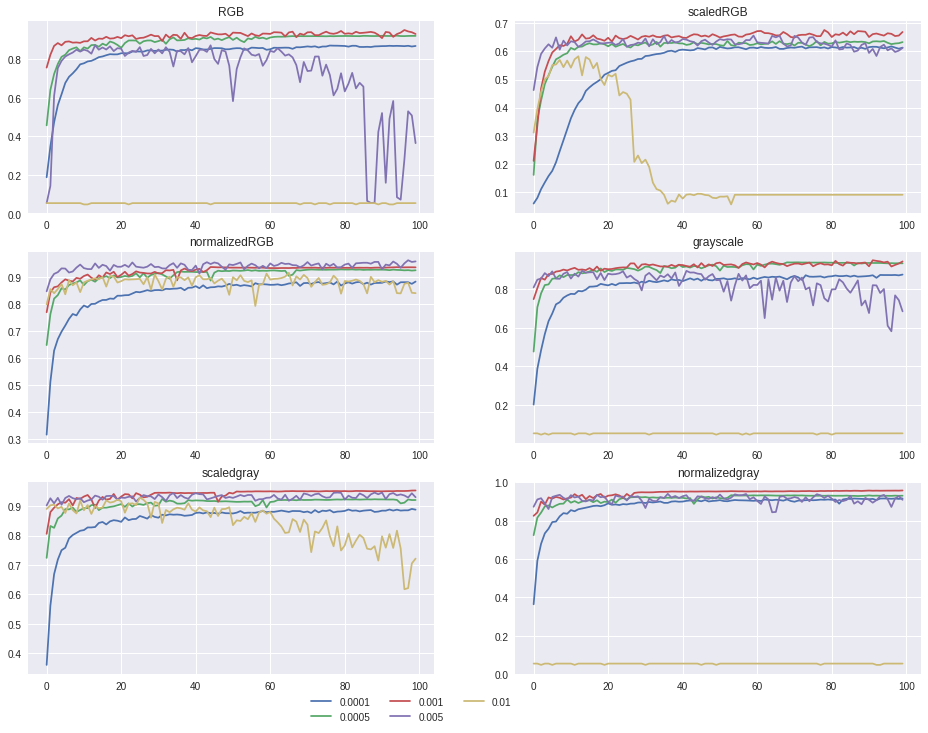

In [25]:
d = []
for root, dirs, files in os.walk('accuracy/'):
    for file in files:
        if not file.startswith('.'):
            d.append(os.path.join(root,file))
            
data = []
for each in d:
    temp1 = np.loadtxt(each)
    temp2 = each.split('/')
    data.append({'Atype': temp2[1], 'PPtype': temp2[2], 'Rate':temp2[3], 'Accuracy': temp1})
    
dataframe = pd.DataFrame(data).sort_values('Atype')

learningrates = [0.0001, 0.0005, 0.001, 0.005, 0.01]

pptypes = ['RGB', 'scaledRGB', 'normalizedRGB', 'grayscale','scaledgray','normalizedgray']
figure = plt.figure(figsize=(16,12))
colorpalette = sns.color_palette(n_colors=5)

for idx,ptype in enumerate(pptypes):
    datatemp = dataframe[(dataframe.Atype == 'validationaccuracy') & (dataframe.PPtype == ptype)].sort_values('Rate')

    subplot = figure.add_subplot(3,2,idx+1)
    accdata = datatemp.Accuracy.tolist()
    labeldata = datatemp.Rate.tolist()
    for idx,plotdata in enumerate(accdata):
        subplot.plot(plotdata, label = labeldata[idx], c = colorpalette[idx])
        subplot.set_title(ptype)
subplot.legend(labeldata,bbox_to_anchor=(0, -0.1), borderaxespad=0., ncol=3)

#### Test the model on test images

In [17]:
prediction_test = tf.nn.softmax(logits)
top5probs = tf.nn.top_k(prediction_test, k=5, sorted = True, name = None)
correct_prediction_test = tf.equal(tf.argmax(logits,1), tf.argmax(one_hot_y,1))
accuracy_operation_test = tf.reduce_mean(tf.cast(correct_prediction_test, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loader = tf.train.import_meta_graph('./lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    print('Session restored')
    print()
    
    # Run prediction to get the softmax probabilities, then use top_k to get the top 5 probabilities.
    # After that run the accuracy operation to print the accuracy of the prediction
    
    pred, top5, cp, acc = sess.run([prediction_test, top5probs, \
                                    correct_prediction_test, \
                                    accuracy_operation_test],\
                                    feed_dict ={x:X_test, y:y_test})
    
    print('{} out of {} images were classified correctly'.format(len(np.where(cp)[0].tolist()),\
                                                                 len(y_test)))
    
    print('The accuracy is {:.2f}'.format(acc))




Session restored

11308 out of 12630 images were classified correctly
The accuracy is 0.90


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

5 images are saved in the folder - **germantrafficsigns**

the corresponding labels are

1. Children Crossing - 28
2. Go straight or right - 36
3. Dangerous Curve left - 19
4. Roundabout mandatory - 40
5. Turn Right ahead - 33


### Load and Output the Images

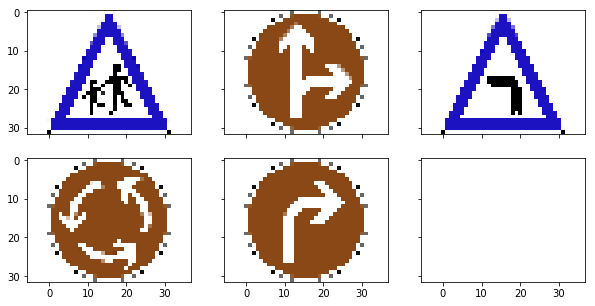

In [23]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

folder = os.path.join('/home','raja','Documents','CarND-Traffic-Sign-Classifier-Project', 'germantrafficsigns')
testimages = []

for index, file in enumerate(os.listdir(folder)):
    img = cv2.imread(os.path.join(folder,file))
    img = cv2.resize(img,(32,32),interpolation=cv2.INTER_LANCZOS4)
    testimages.append(img)
    
test_images = np.array(testimages)

fig ,axs=plty.subplots(2,3, sharex='col', sharey='row', figsize = (10,5))
ax=axs.ravel()
for i,someargs in enumerate(test_images):
    ax[i].imshow(someargs)
    
X_testfinal = preprocessing(test_images,1).astype(np.float32)

labels_test = np.array([28,36,19,40,33])

    


### Predict the Sign Type for Each Image

In the previous session, we have a neural network that is trained in the training data and the accuracy is evaluated using the evaluation set. Now, we have to evaluate accuracy for the 5 images that we have imported along with their labels. So we can keep the prediction part as it is and use use tf.nn.softmax function to print the required results

### Analyze Performance

We can use the same accuracy operation tensor we created earlier. But instead of using the encoded labels we used before, we use the new set of encoded labels for evaluating the accuracy

In [21]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
one_hot_y_test = tf.one_hot(labels_test,43)
prediction_test = tf.nn.softmax(logits)
top5probs = tf.nn.top_k(prediction_test, k=5, sorted = True, name = None)
correct_prediction_test = tf.equal(tf.argmax(logits,1), tf.argmax(one_hot_y_test,1))
accuracy_operation_test = tf.reduce_mean(tf.cast(correct_prediction_test, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loader = tf.train.import_meta_graph('./lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    print('Session restored')
    print()
    
    # Run prediction to get the softmax probabilities, then use top_k to get the top 5 probabilities.
    # After that run the accuracy operation to print the accuracy of the prediction
    
    pred, top5, cp, acc = sess.run([prediction_test, top5probs, \
                                    correct_prediction_test, \
                                    accuracy_operation_test],\
                                    feed_dict ={x:X_testfinal, y:labels_test})
    
    print('{} out of {} images were classified correctly'.format(len(np.where(cp)[0].tolist()),\
                                                                 len(labels_test)))
    print('Index of the correctly classifier images is',np.where(cp)[0].tolist())
    print()
    print('The accuracy is {:.2f}'.format(acc))

    

Session restored

3 out of 5 images were classified correctly
Index of the correctly classifier images is [1, 2, 4]

The accuracy is 0.60


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

### Softmax Probabilities
The softmax probabilities are already stored in the top5 variable in the previous tf session. we just print the variable here

In [22]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
print('The top 5 softmax probabilities are')
print()
top5[0]

The top 5 softmax probabilities are



array([[  1.00000000e+00,   3.33411359e-18,   1.85388858e-25,
          7.00757651e-28,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   7.39740775e-14,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]], dtype=float32)

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the IPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 